# Generate the Clock Test Plot
### Setup

In [29]:
from __future__ import division

import os

from pymongo import MongoClient
from pandas import DataFrame
from numpy import linspace

from cogent.maths.stats import chisqprob
from IPython.display import display, Image

In [20]:
%load_ext rpy2.ipython
%R library(ggplot2)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], 
      dtype='|S9')

In [21]:
try:
    os.mkdir('clock')
except OSError:
    pass

### Utility

In [22]:
def get_ps(nul_col, alt_col):
    nul_fits = {d['_id'] : (d['lf']['ll'], d['lf']['df']) for d in nul_col.find()}
    alt_fits = {d['_id'] : (d['lf']['ll'], d['lf']['df']) for d in alt_col.find()}
    ps = []
    for _id in nul_fits:
        alt_ll, alt_df = alt_fits[_id]
        nul_ll, nul_df = nul_fits[_id]
        lr = 2.*(alt_ll - nul_ll)
        df = alt_df - nul_df
        ps.append(0. if lr < 0. else chisqprob(lr, df))
    return sorted(ps)

### Load the Data

In [23]:
client = MongoClient()

In [24]:
ps = get_ps(client.mammals.GNC_clock, client.mammals.GNC)
ys = linspace(0., 1., len(ps)).tolist()
model = ['GNC']*len(ps)
ps += get_ps(client.mammals.Y98_clock, client.mammals.Y98GTR)
ys += linspace(0., 1., len(ps) - len(model)).tolist()
model += ['Y98']*(len(ps) - len(model))
ps += get_ps(client.mammals.CNFGTR_clock, client.mammals.CNFGTR)
ys += linspace(0., 1., len(ps) - len(model)).tolist()
model += ['CNFGTR']*(len(ps) - len(model))

df = DataFrame({'p':ps, 'y':ys, 'model':model})

### Draw the Plot

In [27]:
%%R -i df
gg <- ggplot(df, aes(p, y, linetype=model)) + geom_line() +
    ylab('Empirical CDF') + 
    xlab('LRT P-value for Human/Mouse Molecular Clock')

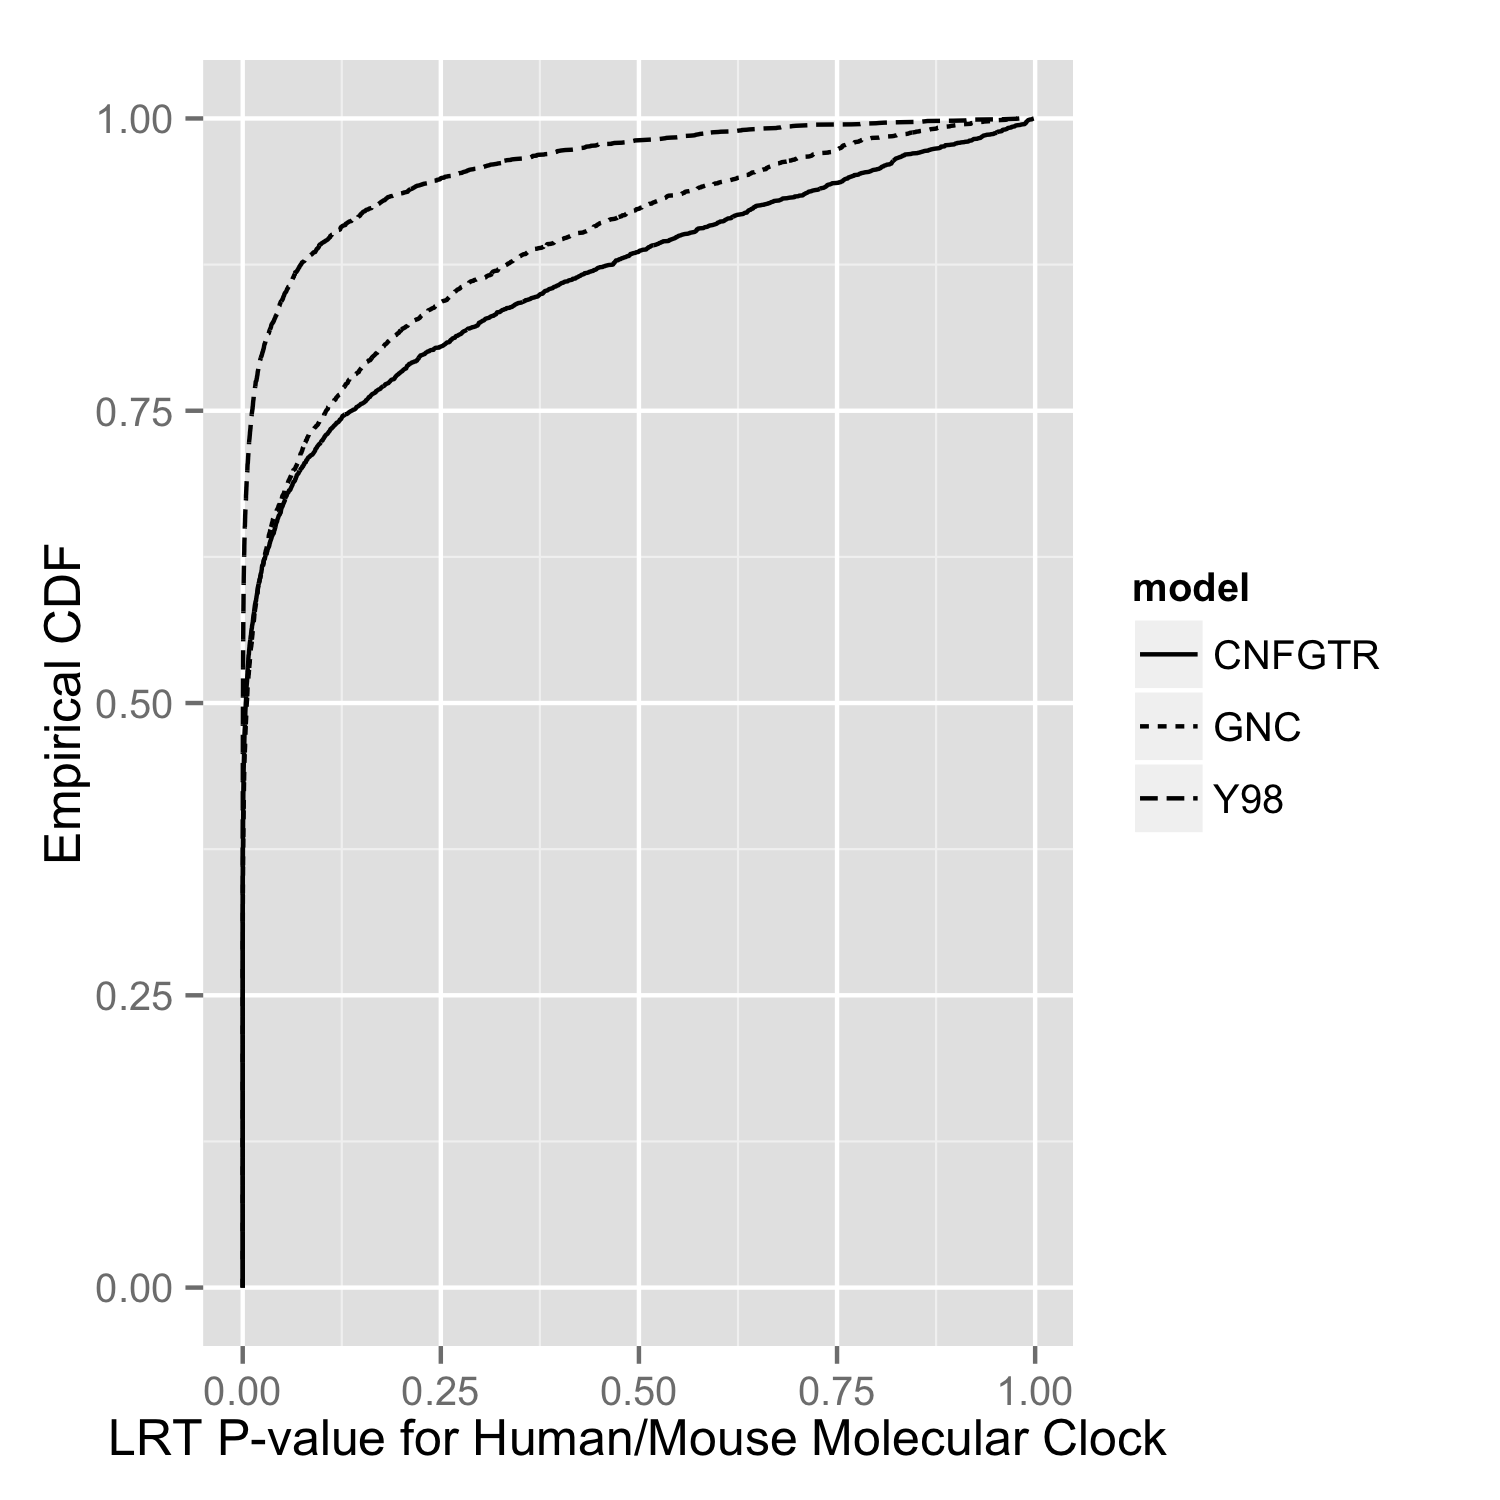

In [30]:
name = os.path.join('clock', 'clock_test.png')
%R -i name ggsave(name, gg, width=5, height=5)
display(Image(name))

In [31]:
sum(p == 0. for p in ps)/len(ps)

0.013734939759036145